## compute_mean_stratif

compute (temporal) mean temperature and salinity, then compute stratification.
Store in a netCDF dataset.

In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

from pathlib import Path

import numpy as np
import xarray as xr
from xgcm import Grid

import sys
sys.path.append("code/")
from xorca.lib import load_xorca_dataset
from eosbn2_xr import eosbn2

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client


/opt/miniconda3/envs/xorca/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55697 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:55698 Dashboard: http://127.0.0.1:55697/status,Cluster Workers: 8 Cores: 8 Memory: 11.18 GiB


In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2010m01d??.1h_*_0-botm.nc"
grid_fname = ["mesh_*_eNATL60NOE_3.6.nc", "mask_eNATL60NOE_3.6.nc"]

data_files = list(data_path.glob(data_fname))
grid_files = sum([list(data_path.glob(fna)) for fna in grid_fname],[]) # trick to flatten: sum([list_of_list],[])

In [4]:
%%time
%%memit
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
grid = Grid(ds_tot, metrics=metrics, periodic=False)

dataset is 75.3 GB
peak memory: 582.73 MiB, increment: 445.21 MiB
CPU times: user 11.3 s, sys: 379 ms, total: 11.6 s
Wall time: 12.1 s


In [5]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 744, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

In [6]:
%%time
%%memit
### compute mean and store in a netCDF file

do_cal = False
mean_file = "eNATL60NOE_mean_strat.nc"
mean_file = data_path/mean_file

if do_cal:
    ds_moy = ds_tot.get(["vosaline","votemper"]).mean("t").assign_coords(z_l=ds_tot.z_l)
    ds_moy.to_netcdf(mean_file, mode="w")
    del ds_moy
    
ds_moy = xr.load_dataset(mean_file)

if "z_l" not in ds_moy: # for previous versions
    ds_moy = ds_moy.assign_coords(z_l=ds_tot.z_l)
    
print("ds_moy is {:.2e} MB".format(ds_moy.nbytes/1e6))

ds_moy is 1.06e+02 MB
ds_moy is 1.06e+02 MB
peak memory: 779.54 MiB, increment: 201.82 MiB
CPU times: user 326 ms, sys: 130 ms, total: 455 ms
Wall time: 1.13 s


In [7]:
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z_c: 300, z_l: 300)
Coordinates:
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    depth_c   (z_c) float64 -0.4805 -1.559 -2.794 ... -5.975e+03 -6.025e+03
    llat_cc   (y_c, x_c) float32 28.99 28.99 28.99 28.99 ... 30.99 30.99 30.99
    llon_cc   (y_c, x_c) float32 -31.0 -30.98 -30.97 ... -29.03 -29.02 -29.0
    e1t       (y_c, x_c) float64 1.622e+03 1.622e+03 ... 1.59e+03 1.59e+03
    e2t       (y_c, x_c) float64 1.627e+03 1.627e+03 ... 1.598e+03 1.598e+03
    e3t       (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... 50.92 50.92 50.92
    tmask     (z_c, y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
    depth_l   (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    vosaline  (z_c, y_c, x_c) float32 36.91 36.9 36.9 36.9 ... 0.0 0.0 0.0 0.0
    votemper  (z_c, y_c, x_c) float32 21.47 21.47 21.47 21.47 ... 0.0 0.0 0.0
    Nsqr      (z_l, y_c, x_c) float32 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan

CPU times: user 4.23 s, sys: 1.85 s, total: 6.08 s
Wall time: 7.12 s


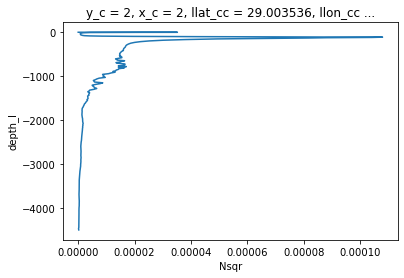

In [8]:
%%time
ds_moy["Nsqr"] = eosbn2(ds_moy.where(ds_moy.tmask), grid=grid).astype(np.float32, casting="same_kind")
ds_moy.Nsqr.isel(x_c=1, y_c=1).plot(y="depth_l")


In [9]:
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z_c: 300, z_l: 300)
Coordinates:
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    depth_c   (z_c) float64 -0.4805 -1.559 -2.794 ... -5.975e+03 -6.025e+03
    llat_cc   (y_c, x_c) float32 28.99 28.99 28.99 28.99 ... 30.99 30.99 30.99
    llon_cc   (y_c, x_c) float32 -31.0 -30.98 -30.97 ... -29.03 -29.02 -29.0
    e1t       (y_c, x_c) float64 1.622e+03 1.622e+03 ... 1.59e+03 1.59e+03
    e2t       (y_c, x_c) float64 1.627e+03 1.627e+03 ... 1.598e+03 1.598e+03
    e3t       (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... 50.92 50.92 50.92
    tmask     (z_c, y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
    depth_l   (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    vosaline  (z_c, y_c, x_c) float32 36.91 36.9 36.9 36.9 ... 0.0 0.0 0.0 0.0
    votemper  (z_c, y_c, x_c) float32 21.47 21.47 21.47 21.47 ... 0.0 0.0 0.0
    Nsqr      (z_l, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>

In [19]:
%%time
ds_moy.to_netcdf(mean_file, mode="w")

CPU times: user 1.44 s, sys: 367 ms, total: 1.81 s
Wall time: 2.46 s
